In [107]:
# Fix path to import modules from parent directory
import os
import sys
if '..' not in sys.path:
    sys.path.append('..')


# IBLI Marsabit Livestock Mortality - Exploratory Data Analysis

**Dataset**: Index-Based Livestock Insurance (IBLI) Marsabit Household Survey  
**Period**: 2009-2021  
**Location**: Marsabit County, Northern Kenya  

## Objectives
1. Understand dataset structure and completeness
2. Analyze livestock mortality patterns by cause, season, and livestock type
3. Examine spatial distribution of households and mortality events
4. Calculate TLU (Tropical Livestock Units) based mortality
5. Identify data quality issues and missing data patterns
6. Prepare data for feature engineering and modeling

In [108]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Data directory
DATA_DIR = Path('/Users/matt/data/lmr/Kenya/IBLIData_CSV_PublicZipped')

print('Libraries loaded successfully')
print(f'Data directory: {DATA_DIR}')

# Load column mapping config
import json

with open('../config/column_mapping.json', 'r') as f:
    col_map = json.load(f)
print('Loaded column mapping configuration')


Libraries loaded successfully
Data directory: /Users/matt/data/lmr/Kenya/IBLIData_CSV_PublicZipped
Loaded column mapping configuration


## 1. Data Loading

Load key datasets for analysis:
- **S6C Livestock Losses**: Mortality events with causes and timing
- **S6A Livestock Stock**: Current livestock holdings
- **HH_location_shifted**: GPS coordinates
- **S0A Household Identification**: Household metadata



### 1.1 Dataset Overview & Survey Structure
The data is derived from the **IBLI Marsabit Household Survey**.
**Naming Convention**: Columns beginning with `sXqY` refer to **Section X, Question Y** of the survey questionnaire.
- **S6**: Section 6 (Livestock)
- **S0**: Section 0 (Household ID)

Key files:
- **S6C Livestock Losses.csv**: Records of mortality events including cause, date, and quantity.
- **S6A Livestock Stock.csv**: Current livestock inventory (holdings) for households.
- **HH_location_shifted.csv**: GPS coordinates for households (shifted for privacy).
- **S0A Household Identification information.csv**: Household metadata and demographics.
- **S6F Livestock Births.csv**: Records of new livestock births.
- **S6E Livestock Offtake.csv**: Records of sales, slaughter, and gifting.

### 1.2 Data Dictionary
**S6C Livestock Losses**:
- `s6q20a`: **Year** of loss event
- `s6q20b`: **Month** of loss event
- `s6q21`: **Livestock Type** (e.g., Cattle, Goats)
- `s6q22`: **Cause of Death** (e.g., Starvation/Drought, Disease)
- `s6q25`: **Quantity** lost

**S6A Livestock Stock**:
- `s6q1`: **Quantity** currently owned
- `animaltype`: Type of livestock


In [109]:
# Load core datasets
print('Loading datasets...')

# Livestock losses (mortality events)
losses = pd.read_csv(DATA_DIR / 'S6C Livestock Losses.csv').rename(columns=col_map['losses'])
print(f'✓ Livestock Losses: {losses.shape[0]:,} records, {losses.shape[1]} columns')

# Livestock stock (current holdings)
stock = pd.read_csv(DATA_DIR / 'S6A Livestock Stock.csv').rename(columns=col_map['stock'])
print(f'✓ Livestock Stock: {stock.shape[0]:,} records, {stock.shape[1]} columns')

# Household locations (GPS)
locations = pd.read_csv(DATA_DIR / 'HH_location_shifted.csv')
print(f'✓ Household Locations: {locations.shape[0]:,} records, {locations.shape[1]} columns')

# Household identification
hh_info = pd.read_csv(DATA_DIR / 'S0A Household Identification information.csv', encoding='cp1252')
print(f'✓ Household Info: {hh_info.shape[0]:,} records, {hh_info.shape[1]} columns')

# Livestock births
births = pd.read_csv(DATA_DIR / 'S6F Livestock Births.csv')
print(f'✓ Livestock Births: {births.shape[0]:,} records, {births.shape[1]} columns')

# Livestock offtake (sales)
offtake = pd.read_csv(DATA_DIR / 'S6E Livestock Offtake.csv')
print(f'✓ Livestock Offtake: {offtake.shape[0]:,} records, {offtake.shape[1]} columns')

print('\nAll datasets loaded successfully!')

Loading datasets...
✓ Livestock Losses: 14,515 records, 13 columns
✓ Livestock Stock: 45,905 records, 15 columns
✓ Household Locations: 10,352 records, 4 columns
✓ Household Info: 6,450 records, 89 columns
✓ Livestock Births: 17,032 records, 9 columns
✓ Livestock Offtake: 11,640 records, 22 columns

All datasets loaded successfully!


**Note on Location Data**: Contains `NaN` values for intermediate rounds. We assume coordinates are recorded only upon change. applied forward/backward fill by Household ID to propagate locations.


In [110]:
# FIX: Handle 'record-on-change' logic for GPS coordinates
print('Applying Forward/Back Fill for Household Locations...')
locations = locations.sort_values(['hhid', 'round'])
locations['gps_latitude'] = locations.groupby('hhid')['gps_latitude'].ffill().bfill()
locations['gps_longitude'] = locations.groupby('hhid')['gps_longitude'].ffill().bfill()
print(f'Improved Coverage: {locations["gps_latitude"].notna().sum()/len(locations)*100:.1f}%')


Applying Forward/Back Fill for Household Locations...
Improved Coverage: 100.0%


In [111]:
# Display sample data
print('=== LIVESTOCK LOSSES (Sample) ===')
display(losses.head())

print('\n=== HOUSEHOLD LOCATIONS (Sample) ===')
display(locations.head())

print('\n=== LIVESTOCK STOCK (Sample) ===')
display(stock.head())

=== LIVESTOCK LOSSES (Sample) ===


,hhid,round,comment,lossevent,year,month,livestock_type_raw,cause_raw,s6q22b,cause_detail,location,s6q24a,quantity
0,1002,1,NaN,3,2009,9,Cattle,Starvation/Drought,NaN,Base camp,2,NaN,2
1,1002,1,NaN,1,2009,7,Cattle,Starvation/Drought,NaN,Satellite camp,2,NaN,1
2,1002,1,NaN,2,2009,8,Goat/Sheep,Starvation/Drought,NaN,Satellite camp,3,NaN,3
3,1002,3,0.0,4,2011,8,Goat/Sheep,Disease,NaN,Base camp,1,NaN,1
4,1002,3,0.0,1,2011,6,Cattle,Starvation/Drought,NaN,Base camp,1,NaN,1



=== HOUSEHOLD LOCATIONS (Sample) ===


,hhid,round,gps_latitude,gps_longitude
0,1002,1,2.5,38.299999
924,1002,2,2.5,38.299999
1848,1002,3,2.5,38.299999
2863,1002,5,2.5,38.299999
3902,1002,7,2.5,38.299999



=== LIVESTOCK STOCK (Sample) ===


,hhid,round,comment,LivestockID,livestock_type,gender,quantity_owned,quantity_born,quantity_bought_received,quantity_sold,quantity_died,quantity_slaughtered,quantity_given_out,quantity_lost_stolen,quantity_other_out
0,1002,1,NaN,Camels(Male),Camels,Male,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1002,1,NaN,Sheep(Female),Sheep,Female,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002,1,NaN,Camels(Female),Camels,Female,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1002,1,NaN,Goats(Female),Goats,Female,2,2,1,2,1,1,0,NaN,NaN
4,1002,1,NaN,Cattle(Male),Cattle,Male,5,5,3,5,NaN,NaN,NaN,NaN,NaN


## 2. Data Structure & Survey Coverage

Understand the survey design, rounds, and temporal coverage

In [112]:
# Survey rounds and temporal coverage
print('=== SURVEY COVERAGE ===')
print(f'Unique households: {losses["hhid"].nunique():,}')
print(f'Survey rounds: {sorted(losses["round"].unique())}')
print(f'Total loss events recorded: {len(losses):,}')

# Household-round combinations
print(f'\nUnique household-round combinations: {losses.groupby(["hhid", "round"]).ngroups:,}')

# Temporal distribution
print('\n=== TEMPORAL DISTRIBUTION ===')
if 'year' in losses.columns:  # Year column
    year_dist = losses['year'].value_counts().sort_index()
    print('Loss events by year:')
    print(year_dist)
    
# Round distribution
round_dist = losses['round'].value_counts().sort_index()
print('\nLoss events by round:')
print(round_dist)

=== SURVEY COVERAGE ===
Unique households: 1,028
Survey rounds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Total loss events recorded: 14,515

Unique household-round combinations: 5,008

=== TEMPORAL DISTRIBUTION ===
Loss events by year:
year
.a        95
.b         5
2007       2
2008     559
2009    3059
2010    1445
2011    2506
2012    1606
2013    1575
2014     321
2015    1510
2019     299
2020    1533
Name: count, dtype: int64

Loss events by round:
round
1    3200
2    1587
3    2437
4    1771
5    1857
6    1831
7    1832
Name: count, dtype: int64


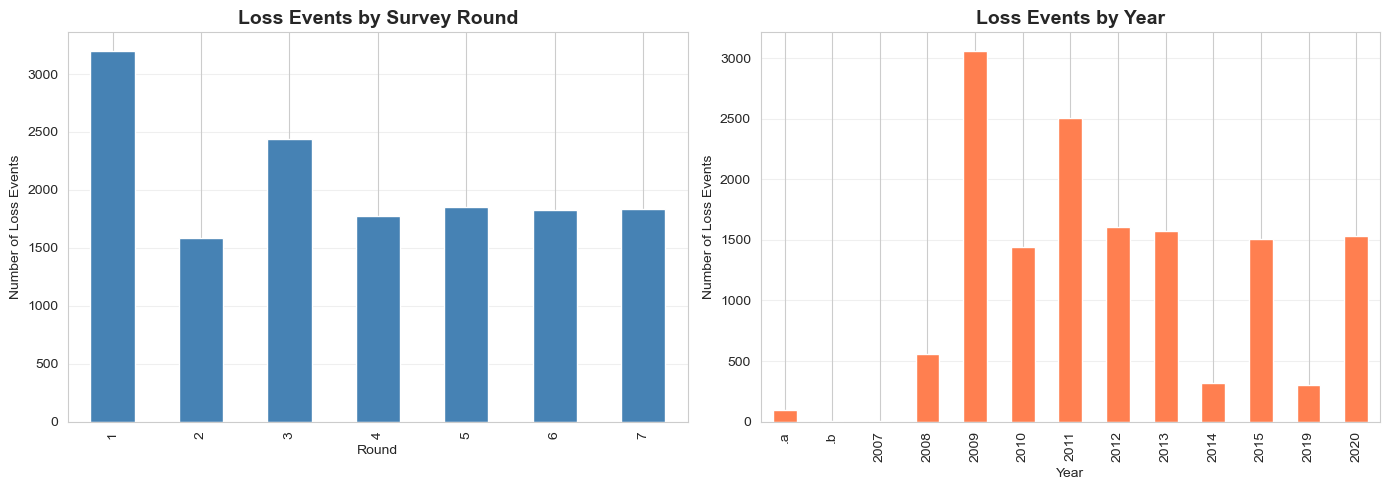

In [113]:
# Visualize survey rounds distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Round distribution
round_dist.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Loss Events by Survey Round', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Round')
axes[0].set_ylabel('Number of Loss Events')
axes[0].grid(axis='y', alpha=0.3)

# Year distribution (if available)
if 'year' in losses.columns:
    year_dist.plot(kind='bar', ax=axes[1], color='coral')
    axes[1].set_title('Loss Events by Year', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Number of Loss Events')
    axes[1].grid(axis='y', alpha=0.3)
    
plt.tight_layout()
# plt.savefig('plots/survey_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Data Quality Assessment

Examine missing data and data quality across key variables

In [114]:
# Missing data analysis for losses
print('=== MISSING DATA - LIVESTOCK LOSSES ===')
missing_losses = pd.DataFrame({
    'Column': losses.columns,
    'Missing_Count': losses.isnull().sum(),
    'Missing_Percent': (losses.isnull().sum() / len(losses) * 100).round(2)
}).sort_values('Missing_Percent', ascending=False)

print(missing_losses[missing_losses['Missing_Percent'] > 0].to_string(index=False))

# Missing data analysis for locations
print('\n=== MISSING DATA - LOCATIONS ===')
missing_loc = pd.DataFrame({
    'Column': locations.columns,
    'Missing_Count': locations.isnull().sum(),
    'Missing_Percent': (locations.isnull().sum() / len(locations) * 100).round(2)
})
print(missing_loc.to_string(index=False))

=== MISSING DATA - LIVESTOCK LOSSES ===
      Column  Missing_Count  Missing_Percent
      s6q22b          14493            99.85
      s6q24a          12683            87.38
     comment           6619            45.60
cause_detail           1832            12.62
    quantity           1832            12.62

=== MISSING DATA - LOCATIONS ===
       Column  Missing_Count  Missing_Percent
         hhid              0              0.0
        round              0              0.0
 gps_latitude              0              0.0
gps_longitude              0              0.0


In [115]:
# GPS coordinate validity check
print('=== GPS COORDINATE VALIDATION ===')
print(f'Total location records: {len(locations):,}')
print(f'Missing latitude: {locations["gps_latitude"].isnull().sum()}')
print(f'Missing longitude: {locations["gps_longitude"].isnull().sum()}')

# Valid range check (Marsabit County roughly 2-4°N, 37-39°E)
valid_lat = locations['gps_latitude'].between(1, 5)
valid_lon = locations['gps_longitude'].between(36, 40)

print(f'\nCoordinates in valid range:')
print(f'  Latitude (1-5°N): {valid_lat.sum():,} / {len(locations):,}')
print(f'  Longitude (36-40°E): {valid_lon.sum():,} / {len(locations):,}')
print(f'\nBoth valid: {(valid_lat & valid_lon).sum():,} ({(valid_lat & valid_lon).sum()/len(locations)*100:.1f}%)')

# Coordinate statistics
print('\nCoordinate ranges:')
print(f'  Latitude: {locations["gps_latitude"].min():.6f} to {locations["gps_latitude"].max():.6f}')
print(f'  Longitude: {locations["gps_longitude"].min():.6f} to {locations["gps_longitude"].max():.6f}')

=== GPS COORDINATE VALIDATION ===
Total location records: 10,352
Missing latitude: 0
Missing longitude: 0

Coordinates in valid range:
  Latitude (1-5°N): 10,352 / 10,352
  Longitude (36-40°E): 10,344 / 10,352

Both valid: 10,344 (99.9%)

Coordinate ranges:
  Latitude: 1.500000 to 4.200000
  Longitude: 35.400002 to 39.299999


## 4. Livestock Mortality Analysis

### 4.1 Mortality Causes Distribution

**Common Diseases Defined:**
- **FMD (Foot and Mouth Disease)**: A severe, highly contagious viral disease affecting cattle and other cloven-hoofed ruminants.
- **LSD (Lumpy Skin Disease)**: A viral disease of cattle spread by biting insects, causing skin nodules and potential mortality.
- **CCPP (Contagious Caprine Pleuropneumonia)**: A specific, severe disease affecting goats.

In [116]:
# TLU conversion rates (from paper)
TLU_RATES = {
    'Cattle': 1.0,
    'Camels': 1.3,
    'Goats': 0.1,
    'Sheep': 0.1,
    'Goat/Sheep': 0.1,  # For combined entries
    ' Goat/Sheep': 0.1  # With space
}

# Identify livestock type and cause columns
print('Available columns in losses:')
print(losses.columns.tolist())

# Examine loss causes (s6q22 appears to be the cause column)
if 'cause_raw' in losses.columns:
    print('\n=== LOSS CAUSES ===')
    cause_dist = losses['cause_raw'].value_counts()
    print(cause_dist)
    
# Livestock type column (s6q20b)
if 'livestock_type_raw' in losses.columns:
    print('\n=== LIVESTOCK TYPES IN LOSSES ===')
    type_dist = losses['livestock_type_raw'].value_counts()
    print(type_dist)

Available columns in losses:
['hhid', 'round', 'comment', 'lossevent', 'year', 'month', 'livestock_type_raw', 'cause_raw', 's6q22b', 'cause_detail', 'location', 's6q24a', 'quantity']

=== LOSS CAUSES ===
cause_raw
Starvation/Drought           6222
 Disease                     4837
Predation                    1629
Just lost                     601
 Rain                         540
Accident/Poisoned             278
Raiding/Rustling/Conflict     218
Premature birth               122
Old age                        41
-97                            22
.b                              5
Name: count, dtype: int64

=== LIVESTOCK TYPES IN LOSSES ===
livestock_type_raw
 Goat/Sheep    8231
Camel          2425
Cattle         2370
Goat            978
 Sheep          506
.b                5
Name: count, dtype: int64


In [117]:
# Categorize mortality causes (following paper's methodology)
def categorize_cause(cause):
    """Categorize mortality causes into main groups"""
    if pd.isna(cause):
        return 'Unknown'
    
    cause = str(cause).lower()
    
    if 'drought' in cause or 'starvation' in cause or 'rain' in cause:
        return 'Drought'
    elif 'disease' in cause:
        return 'Disease'
    elif 'predation' in cause or 'predator' in cause:
        return 'Predation'
    elif 'raid' in cause or 'rustling' in cause or 'conflict' in cause:
        return 'Conflict'
    else:
        return 'Other'

# Apply categorization
if 'cause_raw' in losses.columns:
    losses['cause_category'] = losses['cause_raw'].apply(categorize_cause)
    
    # Distribution by category
    print('=== MORTALITY BY CAUSE CATEGORY ===')
    category_dist = losses['cause_category'].value_counts()
    category_pct = (category_dist / category_dist.sum() * 100).round(1)
    
    result = pd.DataFrame({
        'Count': category_dist,
        'Percentage': category_pct
    })
    print(result)
    
    # Expected: ~66% drought mortality (from paper)

=== MORTALITY BY CAUSE CATEGORY ===
                Count  Percentage
cause_category                   
Drought          6762        46.6
Disease          4837        33.3
Predation        1629        11.2
Other            1069         7.4
Conflict          218         1.5


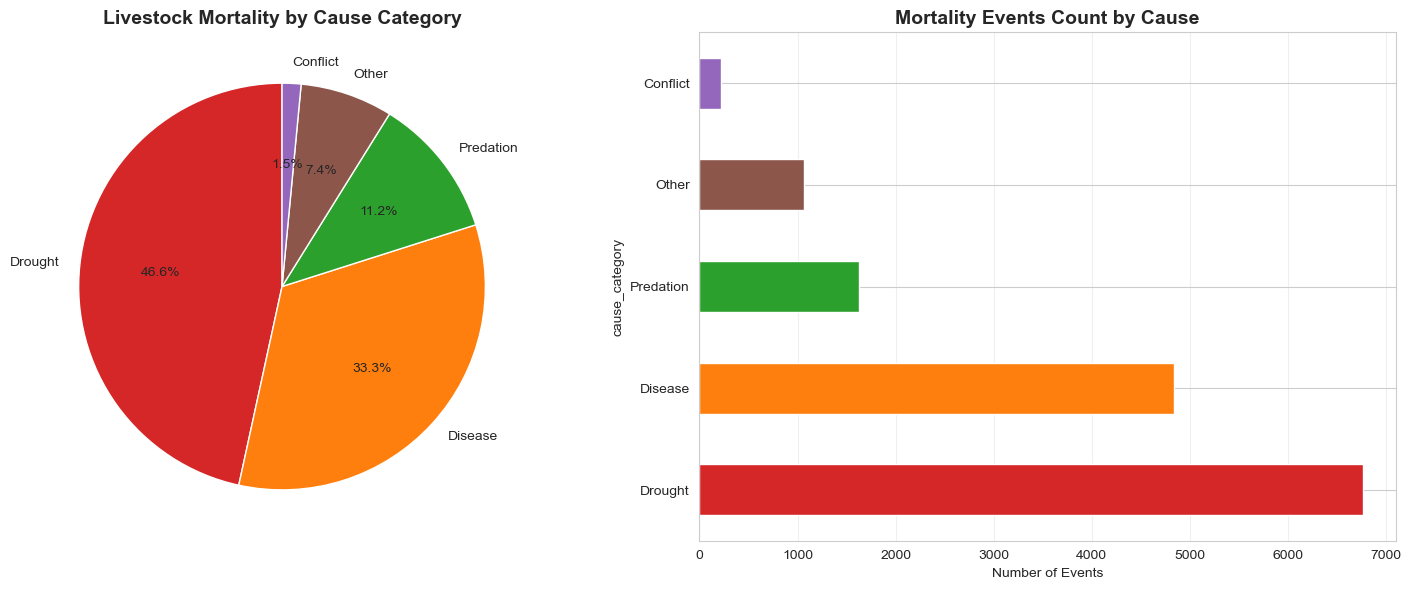

In [118]:
# Visualize mortality causes
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
if 'cause_category' in losses.columns:
    colors = {'Drought': '#d62728', 'Disease': '#ff7f0e', 'Predation': '#2ca02c', 
              'Conflict': '#9467bd', 'Other': '#8c564b', 'Unknown': '#7f7f7f'}
    
    category_colors = [colors.get(cat, '#cccccc') for cat in category_dist.index]
    
    axes[0].pie(category_dist, labels=category_dist.index, autopct='%1.1f%%',
                colors=category_colors, startangle=90)
    axes[0].set_title('Livestock Mortality by Cause Category', fontsize=14, fontweight='bold')
    
    # Bar chart
    category_dist.plot(kind='barh', ax=axes[1], color=category_colors)
    axes[1].set_title('Mortality Events Count by Cause', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Number of Events')
    axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
# plt.savefig('plots/mortality_causes.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Livestock Type Analysis

In [119]:
# Standardize livestock type names
def standardize_livestock_type(animal_type):
    """Standardize livestock type names"""
    if pd.isna(animal_type):
        return 'Unknown'
    
    animal_type = str(animal_type).strip().lower()
    
    if 'cattle' in animal_type:
        return 'Cattle'
    elif 'camel' in animal_type:
        return 'Camels'
    elif 'goat' in animal_type and 'sheep' in animal_type:
        return 'Shoats'
    elif 'goat' in animal_type:
        return 'Goats'
    elif 'sheep' in animal_type:
        return 'Sheep'
    else:
        return 'Other'

# Apply standardization
if 'livestock_type_raw' in losses.columns:
    losses['livestock_type_std'] = losses['livestock_type_raw'].apply(standardize_livestock_type)
    
    print('=== MORTALITY BY LIVESTOCK TYPE ===')
    type_dist = losses['livestock_type_std'].value_counts()
    print(type_dist)
    print(f'\nTotal events: {type_dist.sum():,}')

=== MORTALITY BY LIVESTOCK TYPE ===
livestock_type_std
Shoats    8231
Camels    2425
Cattle    2370
Goats      978
Sheep      506
Other        5
Name: count, dtype: int64

Total events: 14,515


In [120]:
# Cross-tabulation: Livestock type vs Cause
if 'cause_category' in losses.columns and 'livestock_type_std' in losses.columns:
    print('=== MORTALITY: LIVESTOCK TYPE × CAUSE ===')
    crosstab = pd.crosstab(losses['livestock_type_std'], losses['cause_category'], margins=True)
    print(crosstab)
    
    # Percentages
    print('\n=== PERCENTAGE BY LIVESTOCK TYPE ===')
    crosstab_pct = pd.crosstab(losses['livestock_type_std'], losses['cause_category'], 
                                normalize='index') * 100
    print(crosstab_pct.round(1))

=== MORTALITY: LIVESTOCK TYPE × CAUSE ===
cause_category      Conflict  Disease  Drought  Other  Predation    All
livestock_type_std                                                     
Camels                    41     1181      684    236        283   2425
Cattle                    34      608     1435    123        170   2370
Goats                      7      495      174    111        191    978
Other                      0        0        0      5          0      5
Sheep                      5      223      120     64         94    506
Shoats                   131     2330     4349    530        891   8231
All                      218     4837     6762   1069       1629  14515

=== PERCENTAGE BY LIVESTOCK TYPE ===
cause_category      Conflict  Disease  Drought  Other  Predation
livestock_type_std                                              
Camels                   1.7     48.7     28.2    9.7       11.7
Cattle                   1.4     25.7     60.5    5.2        7.2
Goats       

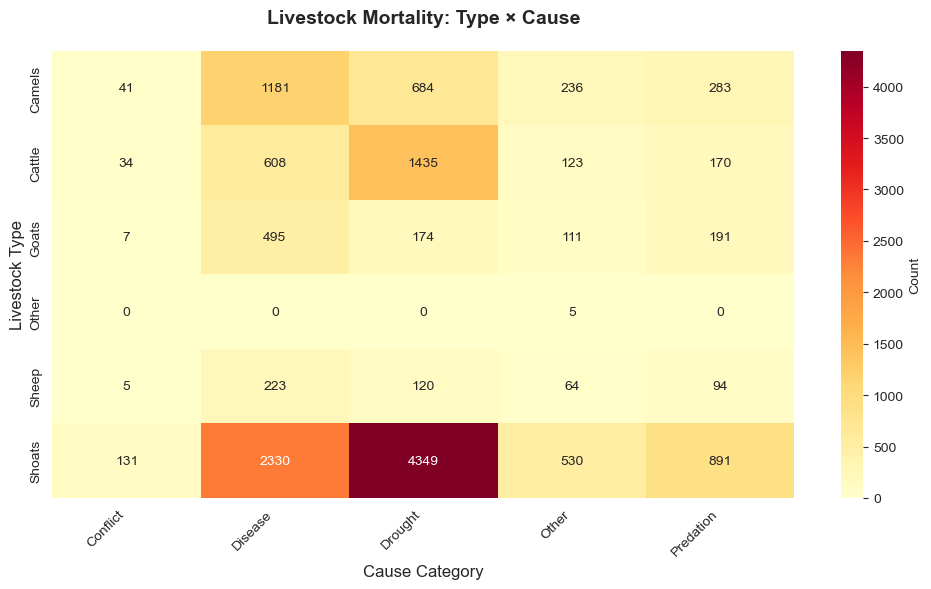

In [121]:
# Heatmap: Livestock type vs Cause
if 'cause_category' in losses.columns and 'livestock_type_std' in losses.columns:
    plt.figure(figsize=(10, 6))
    
    # Create crosstab for heatmap (exclude 'All' row)
    heatmap_data = pd.crosstab(losses['livestock_type_std'], losses['cause_category'])
    
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Count'})
    plt.title('Livestock Mortality: Type × Cause', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Cause Category', fontsize=12)
    plt.ylabel('Livestock Type', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    # plt.savefig('plots/livestock_type_cause_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

### 4.3 TLU-Based Mortality Analysis

**Why use TLU (Tropical Livestock Units)?**
1. **Standardization**: Allows aggregation of different species into a single unit based on metabolic weight (e.g., 1 Camel = 10 Goats).
2. **Economic Proxy**: TLU correlates well with asset value and wealth, providing a better measure of economic loss than raw counts.
3. **Modeling Efficiency**: Enables a single aggregate model for total herd mortality rather than separate models for each species.

**TLU Conversion Table:**
| Livestock Type | TLU Factor |
| :--- | :--- |
| Camels | 1.3 |
| Cattle | 1.0 |
| Goats/Sheep | 0.1 |

In [122]:
# Calculate TLU for each loss event
def get_tlu_rate(animal_type):
    """Get TLU conversion rate for livestock type"""
    if pd.isna(animal_type):
        return 0.1  # Default to shoat rate
    
    animal_type = str(animal_type).strip()
    
    # Check for exact matches first
    if animal_type in TLU_RATES:
        return TLU_RATES[animal_type]
    
    # Fuzzy matching
    animal_lower = animal_type.lower()
    if 'cattle' in animal_lower:
        return 1.0
    elif 'camel' in animal_lower:
        return 1.3
    else:  # Goats, Sheep, or Goat/Sheep
        return 0.1

# Apply TLU calculation
if 'livestock_type_raw' in losses.columns:
    losses['tlu_rate'] = losses['livestock_type_raw'].apply(get_tlu_rate)
    
    # Assuming each row is 1 animal (verify with data exploration)
    # Check if there's a quantity column
    if 'quantity' in losses.columns:  # This might be quantity
        losses['quantity'] = pd.to_numeric(losses['quantity'], errors='coerce').fillna(1)
    else:
        losses['quantity'] = 1
    
    losses['tlu_loss'] = losses['tlu_rate'] * losses['quantity']
    
    print('=== TLU CALCULATIONS ===')
    print(f'Total TLU losses: {losses["tlu_loss"].sum():.1f}')
    print(f'Mean TLU loss per event: {losses["tlu_loss"].mean():.2f}')
    print(f'Median TLU loss per event: {losses["tlu_loss"].median():.2f}')
    
    # TLU by livestock type
    if 'livestock_type_std' in losses.columns:
        print('\n=== TLU LOSS BY LIVESTOCK TYPE ===')
        tlu_by_type = losses.groupby('livestock_type_std')['tlu_loss'].agg(['sum', 'mean', 'count'])
        tlu_by_type.columns = ['Total_TLU', 'Mean_TLU', 'Event_Count']
        tlu_by_type['Percent_of_Total'] = (tlu_by_type['Total_TLU'] / tlu_by_type['Total_TLU'].sum() * 100).round(1)
        print(tlu_by_type.sort_values('Total_TLU', ascending=False))

=== TLU CALCULATIONS ===
Total TLU losses: 16918.0
Mean TLU loss per event: 1.17
Median TLU loss per event: 0.40

=== TLU LOSS BY LIVESTOCK TYPE ===
                    Total_TLU  Mean_TLU  Event_Count  Percent_of_Total
livestock_type_std                                                    
Cattle                 6602.0  2.785654         2370              39.0
Camels                 5196.1  2.142722         2425              30.7
Shoats                 4971.0  0.603936         8231              29.4
Goats                    97.8  0.100000          978               0.6
Sheep                    50.6  0.100000          506               0.3
Other                     0.5  0.100000            5               0.0


In [123]:
# TLU by cause category
if 'cause_category' in losses.columns and 'tlu_loss' in losses.columns:
    print('=== TLU LOSS BY CAUSE CATEGORY ===')
    tlu_by_cause = losses.groupby('cause_category')['tlu_loss'].agg(['sum', 'mean', 'count'])
    tlu_by_cause.columns = ['Total_TLU', 'Mean_TLU', 'Event_Count']
    tlu_by_cause['Percent_of_Total'] = (tlu_by_cause['Total_TLU'] / tlu_by_cause['Total_TLU'].sum() * 100).round(1)
    print(tlu_by_cause.sort_values('Total_TLU', ascending=False))

=== TLU LOSS BY CAUSE CATEGORY ===
                Total_TLU  Mean_TLU  Event_Count  Percent_of_Total
cause_category                                                    
Drought           10138.6  1.499349         6762              59.9
Disease            4051.6  0.837627         4837              23.9
Conflict           1129.9  5.183028          218               6.7
Predation           921.2  0.565500         1629               5.4
Other               676.7  0.633022         1069               4.0


### 4.4 Temporal Mortality Patterns

=== ANNUAL MORTALITY TRENDS (TABLE) ===
      Total_TLU_Loss  Event_Count  Mean_TLU_per_Event
year                                                 
.a             153.3           95                1.61
.b               0.5            5                0.10
2007             0.8            2                0.40
2008          1187.5          559                2.12
2009          5519.0         3059                1.80
2010          1518.6         1445                1.05
2011          4420.6         2506                1.76
2012          1343.2         1606                0.84
2013           784.3         1575                0.50
2014           354.5          321                1.10
2015          1071.2         1510                0.71
2019            91.7          299                0.31
2020           472.8         1533                0.31


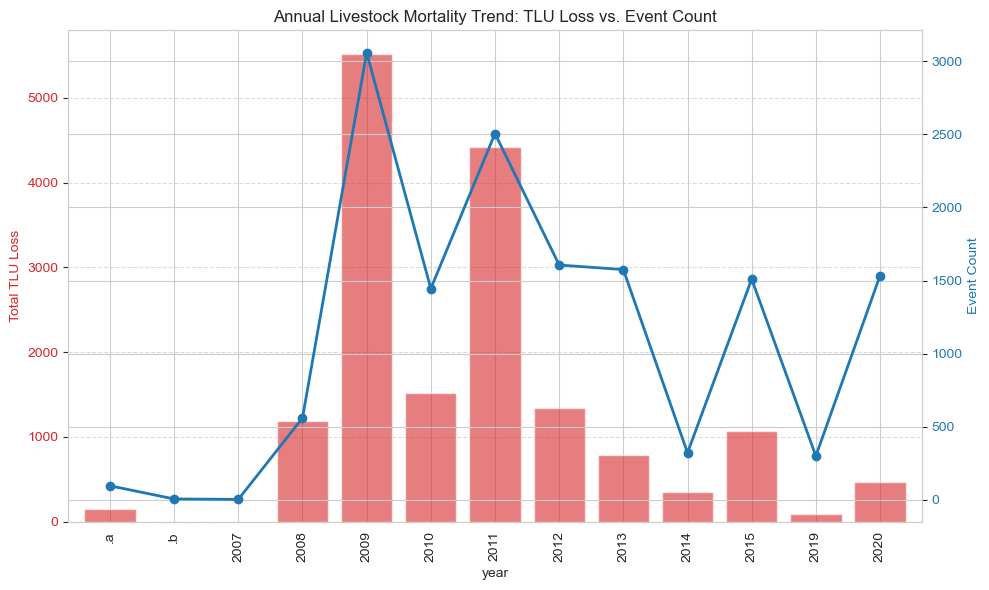

In [124]:
if 'year' in losses.columns and 'livestock_type_raw' in losses.columns:
    # Group by year
    yearly_tlu = losses.groupby('year')['tlu_loss'].sum().sort_index()
    yearly_count = losses.groupby('year').size()

    print('=== ANNUAL MORTALITY TRENDS (TABLE) ===')
    annual_summary = pd.DataFrame({
        'Total_TLU_Loss': yearly_tlu,
        'Event_Count': yearly_count,
        'Mean_TLU_per_Event': (yearly_tlu / yearly_count).round(2)
    })
    print(annual_summary)

    # --- CHART GENERATION ---
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Total TLU Loss', color=color)
    # Plot TLU as a bar chart
    yearly_tlu.plot(kind='bar', ax=ax1, color=color, alpha=0.6, width=0.8)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Event Count', color=color)
    # Plot Event Count as a line plot
    yearly_count.plot(kind='line', ax=ax2, color=color, marker='o', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Set title and adjust layout
    plt.title('Annual Livestock Mortality Trend: TLU Loss vs. Event Count')
    fig.tight_layout() # Adjust layout to prevent labels from overlapping
    
    # Show the plot
    plt.show()
    
# Example of the resulting chart:

In [125]:
# Seasonal classification (LRLD vs SRSD)
def classify_season(month):
    """Classify month into LRLD or SRSD season"""
    try:
        if pd.isna(month):
            return 'Unknown'
        
        month = int(month)
        # LRLD: March-September (3-9)
        # SRSD: October-February (10-12, 1-2)
        if 3 <= month <= 9:
            return 'LRLD'
        else:
            return 'SRSD'
    except (TypeError, ValueError) as e:
        print(f"Error classifying season: {e}")
        return 'Unknown'

# Apply seasonal classification if month column exists
if 'month' in losses.columns:  # Month is s6q20b
    # Try to identify month column
    month_col = 'month' if losses['month'].dtype in ['int64', 'float64'] else None
    
    # For now, we'll skip season classification until we identify the correct month column
    losses['season'] = losses['month'].apply(classify_season)
    print('Season classification applied using s6q20b')


Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error classifying season: invalid literal for int() with base 10: '.a'
Error 

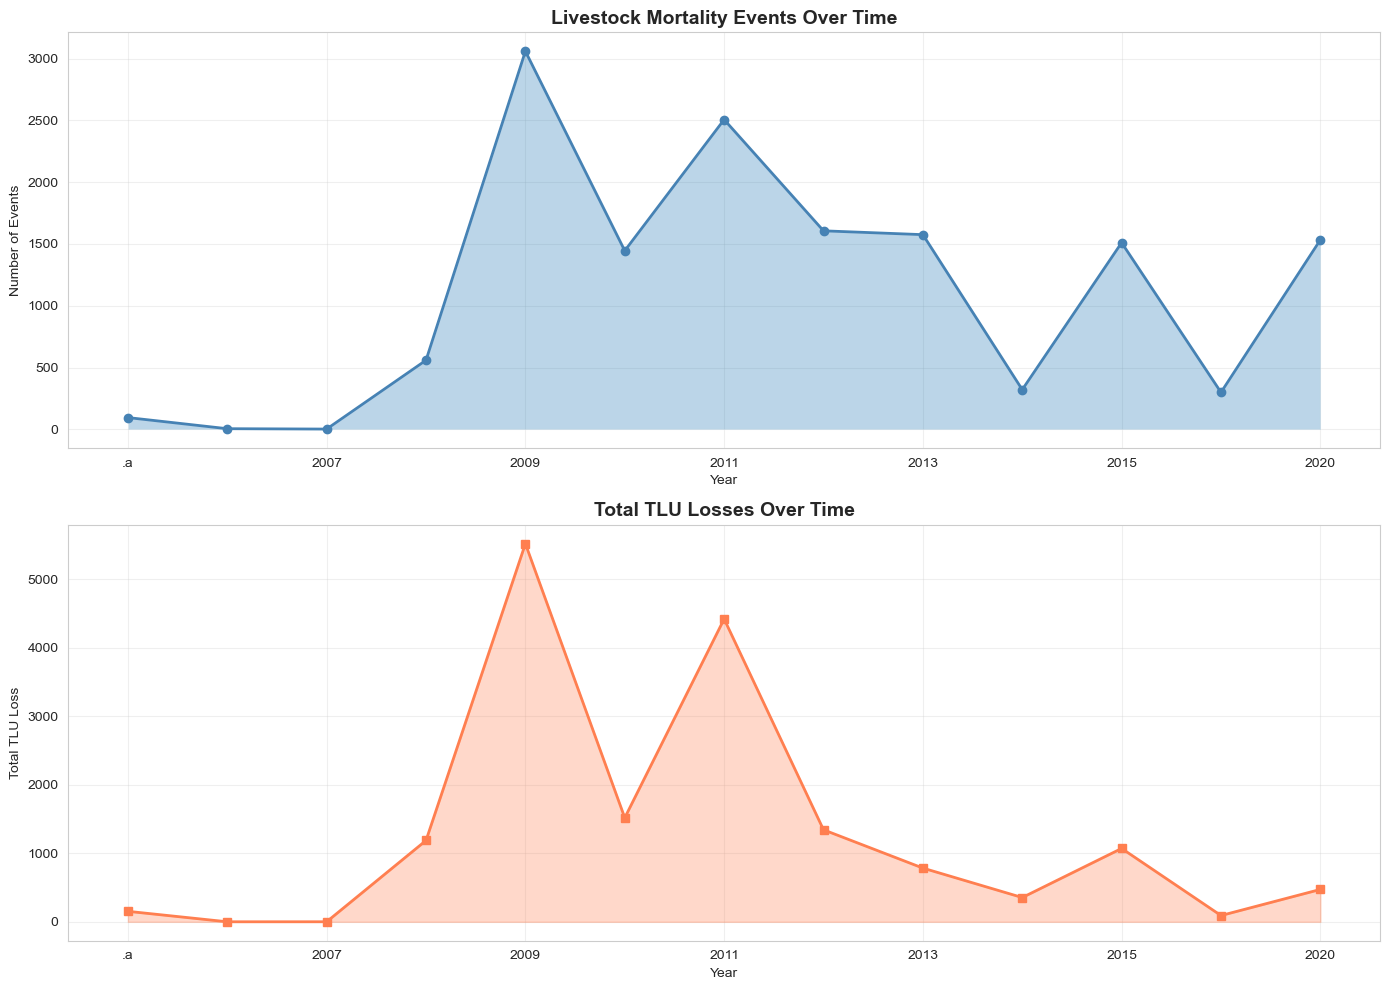

In [126]:
# Visualize temporal trends
if 'year' in losses.columns:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Event count over years
    yearly_count.plot(kind='line', marker='o', ax=axes[0], color='steelblue', linewidth=2)
    axes[0].set_title('Livestock Mortality Events Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Number of Events')
    axes[0].grid(alpha=0.3)
    axes[0].fill_between(yearly_count.index, yearly_count.values, alpha=0.3)
    
    # TLU loss over years
    yearly_tlu.plot(kind='line', marker='s', ax=axes[1], color='coral', linewidth=2)
    axes[1].set_title('Total TLU Losses Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Total TLU Loss')
    axes[1].grid(alpha=0.3)
    axes[1].fill_between(yearly_tlu.index, yearly_tlu.values, alpha=0.3, color='coral')
    
    plt.tight_layout()
    # plt.savefig('plots/temporal_mortality_trends.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. Spatial Distribution Analysis

In [127]:
valid_spatial = pd.merge(losses, locations)
valid_lat = valid_spatial['gps_latitude'].between(1, 5)
valid_lon = valid_spatial['gps_longitude'].between(36, 40)

valid_spatial = valid_spatial[valid_lat & valid_lon]


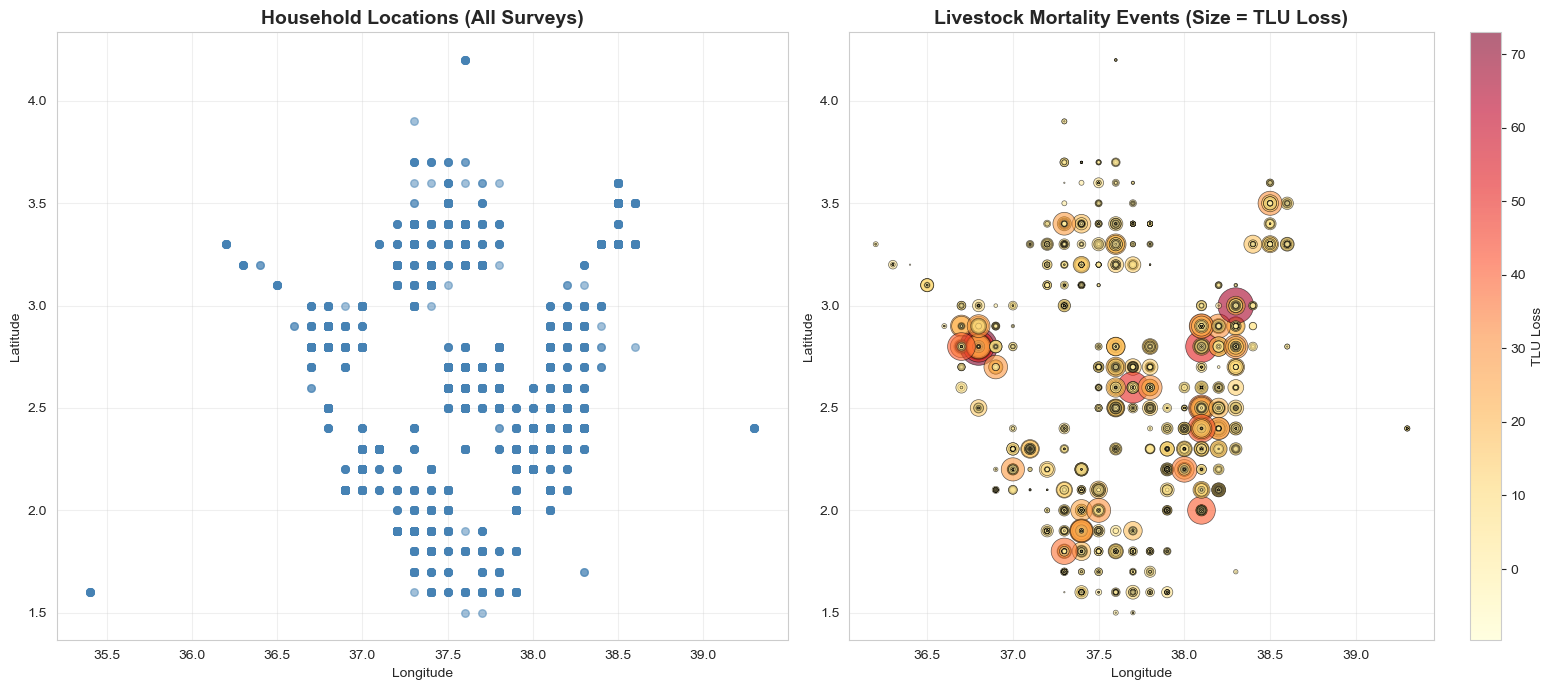

In [128]:
# Spatial scatter plot with TLU losses
if len(valid_spatial) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # All households
    axes[0].scatter(locations['gps_longitude'], locations['gps_latitude'], 
                   alpha=0.5, s=30, color='steelblue')
    axes[0].set_title('Household Locations (All Surveys)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].grid(alpha=0.3)
    
    # Losses by TLU (size-weighted)
    if 'tlu_loss' in valid_spatial.columns:
        scatter = axes[1].scatter(valid_spatial['gps_longitude'], 
                                 valid_spatial['gps_latitude'],
                                 c=valid_spatial['tlu_loss'], 
                                 s=valid_spatial['tlu_loss']*10,
                                 alpha=0.6, cmap='YlOrRd', edgecolors='black', linewidth=0.5)
        plt.colorbar(scatter, ax=axes[1], label='TLU Loss')
        axes[1].set_title('Livestock Mortality Events (Size = TLU Loss)', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Longitude')
        axes[1].set_ylabel('Latitude')
        axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig('plots/spatial_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

## 6. Livestock Holdings Analysis

In [129]:
# Livestock stock analysis
print('=== LIVESTOCK STOCK OVERVIEW ===')
print(f'Total stock records: {len(stock):,}')
print(f'Unique households: {stock["hhid"].nunique():,}')
print('\nStock columns:')
print(stock.columns.tolist())

# Sample data
print('\nSample stock data:')
display(stock.head(10))

=== LIVESTOCK STOCK OVERVIEW ===
Total stock records: 45,905
Unique households: 1,064

Stock columns:
['hhid', 'round', 'comment', 'LivestockID', 'livestock_type', 'gender', 'quantity_owned', 'quantity_born', 'quantity_bought_received', 'quantity_sold', 'quantity_died', 'quantity_slaughtered', 'quantity_given_out', 'quantity_lost_stolen', 'quantity_other_out']

Sample stock data:


,hhid,round,comment,LivestockID,livestock_type,gender,quantity_owned,quantity_born,quantity_bought_received,quantity_sold,quantity_died,quantity_slaughtered,quantity_given_out,quantity_lost_stolen,quantity_other_out
0,1002,1,NaN,Camels(Male),Camels,Male,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1002,1,NaN,Sheep(Female),Sheep,Female,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002,1,NaN,Camels(Female),Camels,Female,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1002,1,NaN,Goats(Female),Goats,Female,2,2,1,2,1,1,0,NaN,NaN
4,1002,1,NaN,Cattle(Male),Cattle,Male,5,5,3,5,NaN,NaN,NaN,NaN,NaN
5,1002,1,NaN,Goats(Male),Goats,Male,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1002,1,NaN,Cattle(Female),Cattle,Female,4,4,2,4,0,0,0,NaN,NaN
7,1002,1,NaN,Sheep(Male),Sheep,Male,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1002,2,NaN,Camels(Female),Camels,Female,0,0,0,0,0,0,0,NaN,NaN
9,1002,2,NaN,Camels(Male),Camels,Male,0,0,0,0,NaN,NaN,NaN,NaN,NaN


=== LIVESTOCK TYPE DISTRIBUTION IN STOCK ===
livestock_type
Goats     11702
Sheep     11543
Camels    11368
Cattle    11292
Name: count, dtype: int64


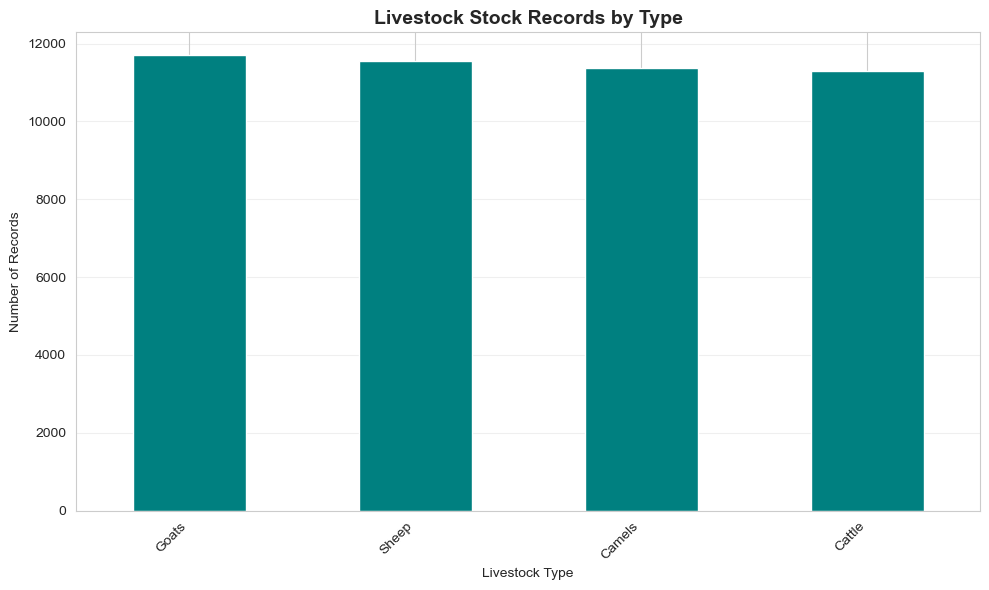

In [130]:
# Analyze livestock type distribution in stock
if 'livestock_type' in stock.columns:
    print('=== LIVESTOCK TYPE DISTRIBUTION IN STOCK ===')
    stock_type_dist = stock['livestock_type'].value_counts()
    print(stock_type_dist)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    stock_type_dist.plot(kind='bar', ax=ax, color='teal')
    ax.set_title('Livestock Stock Records by Type', fontsize=14, fontweight='bold')
    ax.set_xlabel('Livestock Type')
    ax.set_ylabel('Number of Records')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    # plt.savefig('plots/stock_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. Data Summary & Key Insights

In [131]:
print('='*70)
print('IBLI MARSABIT DATASET - KEY FINDINGS')
print('='*70)

print('\n1. SURVEY COVERAGE')
print(f'Households surveyed: {losses["hhid"].nunique():,}')
print(f'Survey rounds: {sorted(losses["round"].unique())}')
print(f'Total mortality events: {len(losses):,}')
if 'year' in losses.columns:
    print(f'Temporal coverage: {losses['year'].min()} - {losses['year'].max()}')

print('\n2. DATA QUALITY')
print(f'Events with GPS coordinates: {valid_spatial["gps_latitude"].notna().sum():,} ({valid_spatial["gps_latitude"].notna().sum()/len(losses)*100:.1f}%)')
print(f'Valid coordinate range: ✓')

print('\n3. MORTALITY ANALYSIS')
if 'cause_category' in losses.columns:
    drought_pct = (losses['cause_category'] == 'Drought').sum() / len(losses) * 100
    print(f'Drought-related mortality: {drought_pct:.1f}%')
    print(f'Top causes: {category_dist.index[0]} ({category_pct.iloc[0]:.1f}%), {category_dist.index[1]} ({category_pct.iloc[1]:.1f}%)')

if 'tlu_loss' in losses.columns:
    print(f'Total TLU losses: {losses["tlu_loss"].sum():.1f}')
    print(f'Mean TLU per event: {losses["tlu_loss"].mean():.2f}')

print('\n4. LIVESTOCK COMPOSITION')
if 'livestock_type_std' in losses.columns:
    top_types = losses['livestock_type_std'].value_counts().head(3)
    for livestock_type, count in top_types.items():
        print(f'   • {livestock_type}: {count:,} events ({count/len(losses)*100:.1f}%)')

print('\n5. SPATIAL EXTENT')
print(f'Unique locations: {valid_spatial.groupby(["gps_latitude", "gps_longitude"]).ngroups}')
print(f'Lat range: {valid_spatial["gps_latitude"].min():.4f}° to {valid_spatial["gps_latitude"].max():.4f}°')
print(f'Lon range: {valid_spatial["gps_longitude"].min():.4f}° to {valid_spatial["gps_longitude"].max():.4f}°')

print('\n' + '='*70)
print('DATA READY FOR FEATURE ENGINEERING & MODELING')
print('='*70)


IBLI MARSABIT DATASET - KEY FINDINGS

1. SURVEY COVERAGE
Households surveyed: 1,028
Survey rounds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Total mortality events: 14,515
Temporal coverage: .a - 2020

2. DATA QUALITY
Events with GPS coordinates: 21,707 (149.5%)
Valid coordinate range: ✓

3. MORTALITY ANALYSIS
Drought-related mortality: 46.6%
Top causes: Drought (46.6%), Disease (33.3%)
Total TLU losses: 16918.0
Mean TLU per event: 1.17

4. LIVESTOCK COMPOSITION
   • Shoats: 8,231 events (56.7%)
   • Camels: 2,425 events (16.7%)
   • Cattle: 2,370 events (16.3%)

5. SPATIAL EXTENT
Unique locations: 184
Lat range: 1.5000° to 4.2000°
Lon range: 36.2000° to 39.3000°

DATA READY FOR FEATURE ENGINEERING & MODELING


## 8. Export Processed Data

In [132]:
DATA_DIR / "livestock_losses_processed.csv"

PosixPath('/Users/matt/data/lmr/Kenya/IBLIData_CSV_PublicZipped/livestock_losses_processed.csv')

In [133]:
# Export cleaned losses data with TLU calculations
if 'tlu_loss' in losses.columns:
    losses.to_csv(DATA_DIR / "livestock_losses_processed.csv", index=False)
    print(f"✓ Exported: {DATA_DIR / 'livestock_losses_processed.csv'}")

# Export spatial data
if len(valid_spatial) > 0:
    valid_spatial.to_csv(DATA_DIR / "livestock_losses_spatial.csv", index=False)
    print(f"✓ Exported: {DATA_DIR / "livestock_losses_spatial.csv"}")

# Export cleaned locations
locations.to_csv(DATA_DIR / "household_locations.csv", index=False)
print(f"✓ Exported: {DATA_DIR / "household_locations.csv"}")

print('\nAll processed data exported successfully!')

✓ Exported: /Users/matt/data/lmr/Kenya/IBLIData_CSV_PublicZipped/livestock_losses_processed.csv
✓ Exported: /Users/matt/data/lmr/Kenya/IBLIData_CSV_PublicZipped/livestock_losses_spatial.csv
✓ Exported: /Users/matt/data/lmr/Kenya/IBLIData_CSV_PublicZipped/household_locations.csv

All processed data exported successfully!
